## The report and code used in project

HOUSEHOLD DEBT AND CREDIT REPORT (Q3 2024)

- Link: https://www.newyorkfed.org/microeconomics/hhdc

Code Source:
- Link: [RAPTOR-Long-Context-RAG-PDF](https://github.com/teddylee777/langchain-kr/blob/main/12-RAG/05-RAPTOR-Long-Context-RAG-PDF.ipynb)


Article:
- RAPTOR : [Link](https://arxiv.org/pdf/2401.18059)

In [1]:
# !pip install -U umap-learn

In [1]:
# API Key
from dotenv import load_dotenv
import warnings

warnings.filterwarnings("ignore")

load_dotenv()

True

In [70]:
# Track LangSmith 
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# Put Project name
logging.langsmith("Personal-Projects")

LangSmith 추적을 시작합니다.
[프로젝트명]
Personal-Projects


In [106]:
FILE_PATH = r"C:\Users\jongb\Documents\langchain-kr\20-Projects\personal_projects\data\HHDC_2024Q3.pdf"

문서의 페이지수: 46


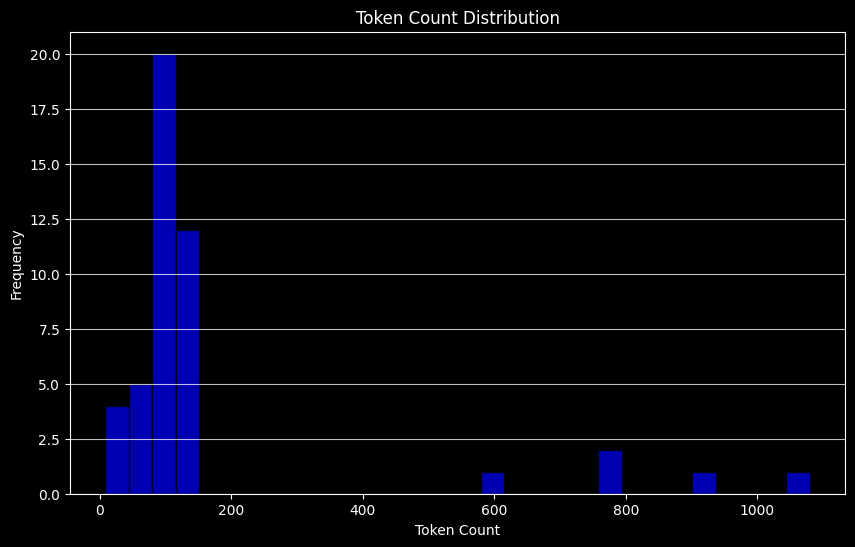

In [107]:
from langchain_community.document_loaders import PDFPlumberLoader
import tiktoken
import matplotlib.pyplot as plt


# 토큰 수 계산
def num_tokens_from_string(string: str, encoding_name: str):
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# 문서 로드(Load Documents)
loader = PDFPlumberLoader(FILE_PATH)
docs = loader.load()
print(f"문서의 페이지수: {len(docs)}")

# 문서 텍스트
docs_texts = [d.page_content for d in docs]

# 각 문서에 대한 토큰 수 계산
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# 토큰 수의 히스토그램을 그립니다.
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# 히스토그램을 표시합니다.
plt.show()

In [108]:
# 문서를 출처 메타데이터 기준으로 정렬합니다.
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# 역순으로 배열된 문서의 내용을 연결합니다.
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

print(
    "전체 토큰 수: %s"  # 모든 문맥에서의 토큰 수를 출력합니다.
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

전체 토큰 수: 8085


In [109]:
# 텍스트 분할을 위한 코드
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 기준 토큰수
chunk_size = 100

# 텍스트 분할기 초기화
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size, chunk_overlap=0
)

# 주어진 텍스트를 분할
texts_split = text_splitter.split_text(concatenated_content)

In [111]:
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore

# cache 저장 경로 지정
store = LocalFileStore("./project_cache/")

# embeddings 인스턴스를 생성
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", disallowed_special=())

# CacheBackedEmbeddings 인스턴스를 생성
cached_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embeddings, store, namespace=embeddings.model
)

## configure model

In [112]:
from langchain_teddynote.messages import stream_response
from langchain_openai import ChatOpenAI


# llm 모델 초기화
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
)

In [113]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
#import umap
import umap.umap_ as umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 42  # 재현성을 위한 고정된 시드 값


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """전역적으로 임베딩 벡터의 차원을 축소하는 함수입니다.

    Args:
        embeddings (np.ndarray): 차원을 축소할 임베딩 벡터들
        dim (int): 축소할 차원의 수
        n_neighbors (Optional[int], optional): UMAP에서 사용할 이웃의 수. 기본값은 None으로, 이 경우 데이터 크기에 따라 자동 계산됨
        metric (str, optional): 거리 계산에 사용할 메트릭. 기본값은 "cosine"

    Returns:
        np.ndarray: 차원이 축소된 임베딩 벡터들
    """
    # 이웃 수 계산
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)

    # UMAP 적용
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """로컬(국소적)하게 임베딩 벡터의 차원을 축소하는 함수입니다.

    Args:
        embeddings (np.ndarray): 차원을 축소할 임베딩 벡터들
        dim (int): 축소할 차원의 수
        num_neighbors (int, optional): UMAP에서 사용할 이웃의 수. 기본값은 10
        metric (str, optional): 거리 계산에 사용할 메트릭. 기본값은 "cosine"

    Returns:
        np.ndarray: 차원이 축소된 임베딩 벡터들
    """
    # UMAP 적용
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

In [114]:
def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """BIC 점수를 기반으로 최적의 클러스터 수를 찾는 함수입니다.

    Args:
        embeddings (np.ndarray): 클러스터링할 임베딩 벡터들
        max_clusters (int, optional): 탐색할 최대 클러스터 수. 기본값은 50
        random_state (int, optional): 난수 생성을 위한 시드값. 기본값은 RANDOM_SEED

    Returns:
        int: BIC 점수가 가장 낮은(최적의) 클러스터 수
    """
    # 최대 클러스터 수와 임베딩의 길이 중 작은 값을 최대 클러스터 수로 설정
    max_clusters = min(max_clusters, len(embeddings))
    # 1부터 최대 클러스터 수까지의 범위를 생성
    n_clusters = np.arange(1, max_clusters)

    # BIC 점수를 저장할 리스트
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        # 학습된 모델의 BIC 점수를 리스트에 추가
        bics.append(gm.bic(embeddings))

    # BIC 점수가 가장 낮은 클러스터 수를 반환
    return n_clusters[np.argmin(bics)]

### Perform Clustering

In [115]:
def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    # 최적의 클러스터 수 산정
    n_clusters = get_optimal_clusters(embeddings)

    # 가우시안 혼합 모델을 초기화
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)

    # 임베딩이 각 클러스터에 속할 확률을 예측
    probs = gm.predict_proba(embeddings)

    # 임계값을 초과하는 확률을 가진 클러스터를 레이블로 선택
    labels = [np.where(prob > threshold)[0] for prob in probs]

    # 레이블과 클러스터 수를 반환
    return labels, n_clusters

In [116]:
def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    임베딩에 대해 계층적 클러스터링을 수행하는 함수입니다.

    전역 차원 축소와 클러스터링을 먼저 수행한 후, 각 전역 클러스터 내에서
    로컬 차원 축소와 클러스터링을 수행합니다.

    Args:
        embeddings (np.ndarray): 클러스터링할 임베딩 벡터들
        dim (int): 차원 축소 시 목표 차원 수
        threshold (float): GMM 클러스터링에서 사용할 확률 임계값

    Returns:
        List[np.ndarray]: 각 데이터 포인트에 대한 로컬 클러스터 레이블 리스트.
                         각 레이블은 해당 데이터 포인트가 속한 로컬 클러스터의 인덱스를 담은 numpy 배열입니다.
    """

    if len(embeddings) <= dim + 1:
        # 데이터가 충분하지 않을 때 클러스터링을 피합니다.
        return [np.array([0]) for _ in range(len(embeddings))]

    # 글로벌 차원 축소
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)

    # 글로벌 클러스터링
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    # 로컬 클러스터링을 위한 초기화
    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # 각 글로벌 클러스터를 순회하며 로컬 클러스터링 수행
    for i in range(n_global_clusters):
        # 현재 글로벌 클러스터에 속하는 임베딩 추출
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # 작은 클러스터는 직접 할당으로 처리
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # 로컬 차원 축소 및 클러스터링
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # 로컬 클러스터 ID 할당, 이미 처리된 총 클러스터 수를 조정
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters

In [117]:
def embed(texts):
    """
    주어진 텍스트 리스트를 임베딩 벡터로 변환합니다.

    Args:
        texts (List[str]): 임베딩할 텍스트 리스트

    Returns:
        np.ndarray: 텍스트의 임베딩 벡터를 포함하는 numpy 배열
                   shape은 (텍스트 개수, 임베딩 차원)입니다.
    """
    text_embeddings = embeddings.embed_documents(texts)

    # 임베딩을 numpy 배열로 변환
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np

In [118]:
def embed_cluster_texts(texts):
    # 임베딩 생성
    text_embeddings_np = embed(texts)
    # 클러스터링 수행
    cluster_labels = perform_clustering(text_embeddings_np, 10, 0.1)
    # 결과를 저장할 DataFrame 초기화
    df = pd.DataFrame()
    # 원본 텍스트 저장
    df["text"] = texts
    # DataFrame에 리스트로 임베딩 저장
    df["embd"] = list(text_embeddings_np)
    # 클러스터 라벨 저장
    df["cluster"] = cluster_labels
    return df

In [119]:
def fmt_txt(df: pd.DataFrame) -> str:
    """
    주어진 DataFrame에서 텍스트 문서를 단일 문자열로 포맷팅하는 함수입니다.

    Args:
        df (pd.DataFrame): 포맷팅할 텍스트 문서를 포함한 DataFrame

    Returns:
        str: 텍스트 문서들을 특정 구분자로 결합한 단일 문자열
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)

In [120]:
def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    텍스트 목록에 대해 임베딩, 클러스터링 및 요약을 수행합니다. 이 함수는 먼저 텍스트에 대한 임베딩을 생성하고,
    유사성을 기반으로 클러스터링을 수행한 다음, 클러스터 할당을 확장하여 처리를 용이하게 하고 각 클러스터 내의 내용을 요약합니다.

    매개변수:
    - texts: 처리할 텍스트 문서 목록입니다.
    - level: 처리의 깊이나 세부 사항을 정의할 수 있는 정수 매개변수입니다.

    반환값:
    - 두 개의 데이터프레임을 포함하는 튜플:
      1. 첫 번째 데이터프레임(`df_clusters`)은 원본 텍스트, 그들의 임베딩, 그리고 클러스터 할당을 포함합니다.
      2. 두 번째 데이터프레임(`df_summary`)은 각 클러스터에 대한 요약, 지정된 세부 수준, 그리고 클러스터 식별자를 포함합니다.
    """

    # 텍스트를 임베딩하고 클러스터링하여 'text', 'embd', 'cluster' 열이 있는 데이터프레임을 생성합니다.
    df_clusters = embed_cluster_texts(texts)

    # 클러스터를 쉽게 조작하기 위해 데이터프레임을 확장할 준비를 합니다.
    expanded_list = []

    # 데이터프레임 항목을 문서-클러스터 쌍으로 확장하여 처리를 간단하게 합니다.
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # 확장된 목록에서 새 데이터프레임을 생성합니다.
    expanded_df = pd.DataFrame(expanded_list)

    # 처리를 위해 고유한 클러스터 식별자를 검색합니다.
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # 요약
    template = """여기 LangChain 표현 언어 문서의 하위 집합이 있습니다.
    
    LangChain 표현 언어는 LangChain에서 체인을 구성하는 방법을 제공합니다.
    
    제공된 문서의 자세한 요약을 제공하십시오.
    
    문서:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()

    # 각 클러스터 내의 텍스트를 요약을 위해 포맷팅합니다.
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # 요약, 해당 클러스터 및 레벨을 저장할 데이터프레임을 생성합니다.
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary

In [121]:
def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    # 각 레벨에서의 결과를 저장할 사전
    results = {}

    # 현재 레벨에 대해 임베딩, 클러스터링, 요약 수행
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # 현재 레벨의 결과 저장
    results[level] = (df_clusters, df_summary)

    # 추가 재귀가 가능하고 의미가 있는지 결정
    unique_clusters = df_summary["cluster"].nunique()

    # 현재 레벨이 최대 레벨보다 낮고, 유니크한 클러스터가 1개 이상인 경우
    if level < n_levels and unique_clusters > 1:
        # 다음 레벨의 재귀 입력 텍스트로 요약 사용
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # 다음 레벨의 결과를 현재 결과 사전에 병합
        results.update(next_level_results)

    return results

In [122]:
# 전체 문서의 개수
len(texts_split)

124

In [123]:
# 트리 구축
leaf_texts = texts_split.copy()

# 재귀적으로 임베딩, 클러스터링 및 요약을 수행하여 결과를 얻음
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 24 clusters--
--Generated 5 clusters--
--Generated 1 clusters--


In [124]:
leaf_texts[:20]

['Delinquency status. Varies between current (paid as agreed), 30-day late (between 30 and 59 day late; not more than 2\npayments past due), 60-day late (between 60 and 89 days late; not more than 3 payments past due), 90-day late (between 90\nand 119 days late; not more than 4 payments past due), 120-day late (at least 120 days past due; 5 or more payments past',
 'due) or collections, and severely derogatory (any of the previous states combined with reports of a repossession, charge off to\nbad debt or foreclosure). Not all creditors provide updated information on payment status, especially after accounts have been\nderogatory for a longer period of time. Thus the payment performance profiles obtained from our data may to some extent\nreflect reporting practices of creditors.',
 'Percent of balance 90+ days late. Percent of balance that is either 90-day late, 120-day late or severely derogatory. 90+ days\nlate is synonymous to seriously delinquent.\nNew foreclosures. Number of indivi

In [125]:
from langchain_community.vectorstores import FAISS

all_texts = leaf_texts.copy()

# 레벨을 정렬하여 순회
for level in sorted(results.keys()):
    # 현재 레벨의 DataFrame에서 요약을 추출
    summaries = results[level][1]["summaries"].tolist()
    # 현재 레벨의 요약을 all_texts에 추가합니다.
    all_texts.extend(summaries)

# 이제 all_texts를 사용하여 FAISS vectorstore를 구축합니다.
vectorstore = FAISS.from_texts(texts=all_texts, embedding=embeddings)

In [126]:
import os

DB_INDEX = "RAPTOR"

# 기존 DB 인덱스가 존재하면 로드하여 vectorstore와 병합한 후 저장합니다.
if os.path.exists(DB_INDEX):
    local_index = FAISS.load_local(DB_INDEX, embeddings)
    local_index.merge_from(vectorstore)
    local_index.save_local(DB_INDEX)
else:
    vectorstore.save_local(folder_path=DB_INDEX)

In [127]:
# retriever 생성
retriever = vectorstore.as_retriever()

## Build RAG chain

In [128]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate

# 프롬프트 정의
prompt = PromptTemplate.from_template(
    """
    You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
You are given PDF documents. Your primary mission is to answer questions based on provided context.
Ensure your response is concise and directly addresses the question without any additional narration.

###

Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names).

# Steps

1. Carefully read and understand the context provided.
2. Identify the key information related to the question within the context.
3. Formulate a concise answer based on the relevant information.
4. Ensure your final answer directly addresses the question.

# Output Format:
[General introduction of the answer]
[Comprehensive answer to the question]

###

Remember:
- It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
- DO NOT use any external knowledge or information not present in the given materials.

###

# Here is the user's QUESTION that you should answer:
{question}

# Here is the CONTEXT that you should use to answer the question:
{context}

[Note]
- Answer should be written in English.

# Your final ANSWER to the user's QUESTION:"""
)


# 문서 포맷팅
def format_docs(docs):
    return "\n\n".join(f"<document>{doc.page_content}</document>" for doc in docs)


# RAG 체인 정의
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [129]:
# high level question
answer = rag_chain.stream("Summarize the main points covered in the full article")
stream_response(answer)

The article covers several key points related to consumer credit data and household debt in the United States, based on data from the New York Federal Reserve and Equifax. The main points include:

1. **Credit Scores and Loan Origination**: It discusses the use of Equifax Risk Score 3.0 to assess consumer credit risk and provides information on the origination of auto and mortgage loans, highlighting the market share of borrowers with high credit scores.

2. **Collection Activities and Data Sampling**: The document notes that most collection activities are related to medical bills and utilities, with the panel designed to track household-level credit and debt, primarily using creditor-reported account information.

3. **Delinquency and Public Records**: It provides information on delinquency rates and the flow into early delinquency, mentioning an increase in delinquency rates during the third quarter of 2024.

4. **Age Groups and Data Discrepancies**: Age groups are redefined annually